In [2]:
from params import FuzzyInputVariable_3Trapezoids, FuzzyInputVariable_2Trapezoids, FuzzyInputVariable_List_Trapezoids
from operators import productN
import numpy as np
#from helps_and_enhancers import *
import matplotlib.pyplot as plt
from ANFIS import ANFIS
import time
import copy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

<H1>Przygotowanie zbioru danych<H1>

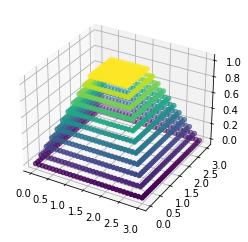

In [3]:
x = np.arange(0, 3.1, 0.1)
x,y = np.meshgrid(x, x)

dataX = x.flatten()
dataY = y.flatten()
dataXY = np.column_stack((dataX,dataY))

data_labels = []
for x, y in zip(dataX, dataY):
    x-=1.5
    y-=1.5
    data_labels.append( abs(x) if (y<x and y>-x) or (y>x and y<-x)  else abs(y) ) 
data_labels=np.array(data_labels)
#data_labels[data_labels>1.5] = 1.5
data_labels=abs(data_labels-1.5)
data_labels[data_labels>1] = 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataX, dataY, data_labels, c=data_labels)

plt.show()

<H1>Utworzenie funkcji przynależności</H1>

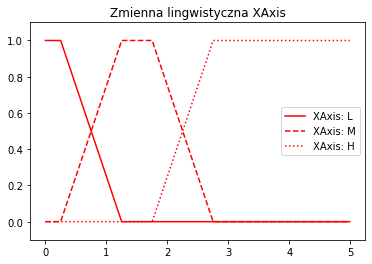

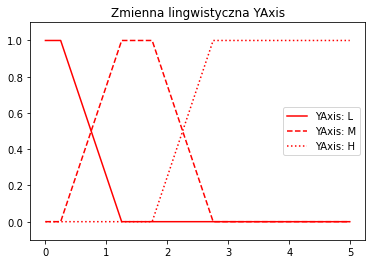

In [4]:
varX = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "XAxis", ["L","M","H"])
varY = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "YAxis", ["L","M","H"])

#Wyświetlanie funkcji przynależnosci
plt.figure()
varX.show(x = np.arange(0, 5, 0.01))
plt.legend()

plt.figure()
varY.show(x = np.arange(0, 5, 0.01))
plt.legend()

plt.show()

<H1>Uczenie systemu ANFIS</H1>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataXY, data_labels, test_size=0.2, random_state=25)

fis = ANFIS([varX, varY], X_train.T, y_train)

start = time.time()
fis.train(True, True, False, True, n_iter=100)
end = time.time()
print("FIS premises", fis.premises)
print("TIME elapsed: ", end - start)   
fis.training_data = X_train.T
fis.expected_labels = y_train
fis.show_results(y_train)

<H1>Zadanie</H1>

Zaimplementuj wszystkie operatory rozmyte pokazane w pliku "Najczęściej stosowane t-normy". Następnie użyj ich do uczenia powyższego systemu ANFIS, która z nich jest najlepsza, jak myślisz dlaczego?

## Normy

In [59]:
def zadeh_t(args, op):  # min(x,y)
    return np.min(args, axis=0)

def zadeh_s(args, op):  # max(x,y)
    return np.max(args, axis=0)

def algebraic_t(args, op):  # x*y
    return np.product(args, axis=0)

def probabilistic_s(args, op):  # x+y-x*y
    return np.sum(args, axis=0) - np.product(args, axis=0)

def lukasiewicz_s(args, op): # min(x+y,1)
    return np.clip(np.sum(args, axis=0), a_min=None, a_max=1)

def lukasiewicz_s(args, op): # min(x+y,1)
    return np.clip(np.sum(args, axis=0) + 1, a_min=None, a_max=1)

def fodor_t(args, op):
    mins = np.min(args, axis=0)
    zeros = np.zeros_like(mins)
    condition = np.sum(args, axis=0) > 1
    return np.where(condition, mins, zeros)

def fodor_s(args, op):
    maxs = np.max(args, axis=0)
    ones = np.ones_like(maxs)
    condition = np.sum(args, axis=0) < 1
    return np.where(condition, maxs, ones)

def drastic_t(args, op):
    assert len(args) == 2
    a, b = args
    return np.select([a == 0, b == 0], [b, a], default=1)

def drastic_s(args, op):
    return 1 - drastic_t(1 - args, op)  # from general c-norm definition

def einstein_t(args, op):
    num = np.product(args, axis=0)
    denom = 2 - ( np.sum(args, axis=0) - num )
    return num / denom

def einstein_s(args, op):
    num = np.sum(args, axis=0)
    denom = 1 + np.product(args, axis=0)
    return num / denom

def hamacher_product(args, op):
    x, y = args
    zeros = np.zeros_like(x)
    condition = np.logical_and(x == 0, y == 0)
    denom = (x + y - x * y)
    denom[denom == 0] = 1e-10
    values = (x * y) / denom
    return np.where(condition, zeros, values)

def bounded_sum(args, op):
    x, y = args
    return np.min([x + y, np.ones_like(x)], axis=0)

\begin{equation*}
E(x,y)=\frac{xy}{2-(x+y-xy)}     \quad\quad\quad\quad     E'(x,y)=\frac{x+y}{1+xy}
\end{equation*}

## Testowanie norm

In [7]:
def test_norm(operator_function):
    varX = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "XAxis", ["L","M","H"])
    varY = FuzzyInputVariable_3Trapezoids(1.5, 0.5, 1, 1, "YAxis", ["L","M","H"])


    X_train, X_test, y_train, y_test = train_test_split(dataXY, data_labels, test_size=0.2, random_state=25)

    fis = ANFIS([varX, varY], X_train.T, y_train, operator_function=operator_function)

    start = time.time()
    fis.train(True, True, False, True, n_iter=100)
    end = time.time()
    fis.training_data = X_train.T
    fis.expected_labels = y_train
    fis.show_results(y_train)

    labels = fis.anfis_estimate_labels(fis.premises, fis.op, fis.tsk)
    err = np.sum(np.abs(labels - fis.expected_labels))
    print(f"Error: {err:.3f}")
    print(f"Time: {end - start:.3f}")

Optymalizacja zakończona!
z blędem:   20.921340344064106
Liczba ew:  280748
Liczba it:  100


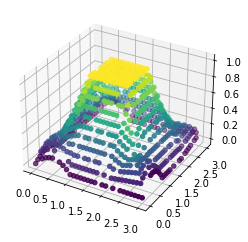

Error: 20.921
Time: 97.459


In [21]:
test_norm(zadeh_t)

Optymalizacja zakończona!
z blędem:   103.75030522222018
Liczba ew:  148805
Liczba it:  100


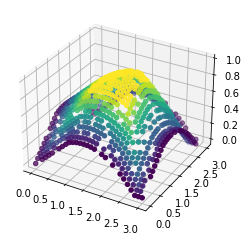

Error: 103.750
Time: 50.435


In [22]:
test_norm(zadeh_s)

Optymalizacja zakończona!
z blędem:   18.319609459825216
Liczba ew:  277943
Liczba it:  100


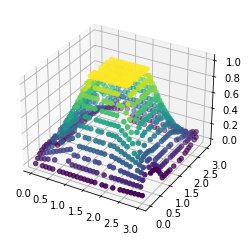

Error: 18.320
Time: 91.171


In [23]:
test_norm(algebraic_t)

Optymalizacja zakończona!
z blędem:   110.2275782682623
Liczba ew:  177115
Liczba it:  100


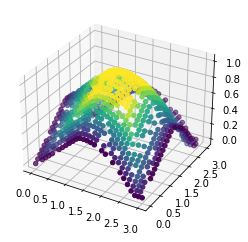

Error: 110.228
Time: 58.431


In [24]:
test_norm(probabilistic_s)

Optymalizacja zakończona!
z blędem:   23.64487230651787
Liczba ew:  329658
Liczba it:  100


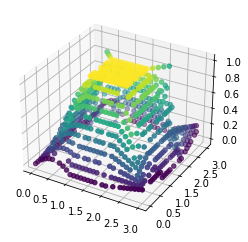

Error: 23.645
Time: 122.951


In [25]:
test_norm(lukasiewicz_t)

Optymalizacja zakończona!
z blędem:   113.23435785789613
Liczba ew:  171010
Liczba it:  100


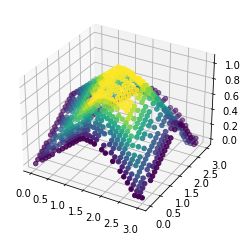

Error: 113.234
Time: 45.816


In [62]:
test_norm(lukasiewicz_s)

C:\Users\Lukasz\OneDrive - Politechnika Łódzka\siium\semestr-2\msi\labs\anfis2\ANFIS.py:97: RuntimeWarning: invalid value encountered in true_divide
  Rnorm = R / Rsum


Optymalizacja zakończona!
z blędem:   51.053718999661456
Liczba ew:  189394
Liczba it:  100


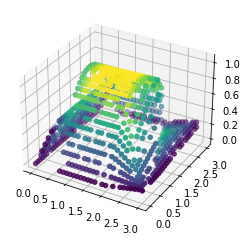

Error: 51.054
Time: 70.961


In [27]:
test_norm(fodor_t)

Optymalizacja zakończona!
z blędem:   110.22757612018685
Liczba ew:  171520
Liczba it:  100


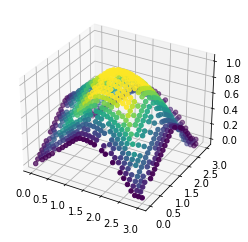

Error: 110.228
Time: 62.346


In [28]:
test_norm(fodor_s)

Optymalizacja zakończona!
z blędem:   114.04653604170728
Liczba ew:  146972
Liczba it:  100


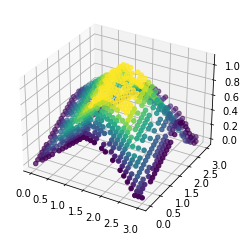

Error: 114.047
Time: 60.557


In [29]:
test_norm(drastic_t)

Optymalizacja zakończona!
z blędem:   83.69922876859937
Liczba ew:  206006
Liczba it:  100


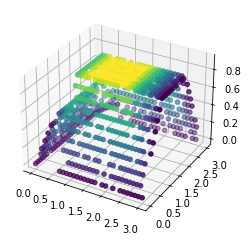

Error: 83.699
Time: 85.131


In [30]:
test_norm(drastic_s)

Optymalizacja zakończona!
z blędem:   17.83979982772992
Liczba ew:  291038
Liczba it:  100


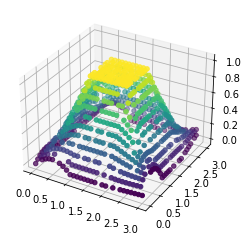

Error: 17.840
Time: 101.638


In [31]:
test_norm(einstein_t)

Optymalizacja zakończona!
z blędem:   111.19534377053243
Liczba ew:  174405
Liczba it:  100


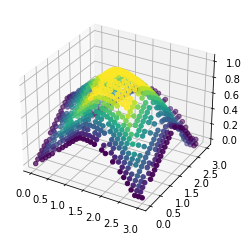

Error: 111.195
Time: 57.936


In [32]:
test_norm(einstein_s)

Optymalizacja zakończona!
z blędem:   20.639329897267732
Liczba ew:  282458
Liczba it:  100


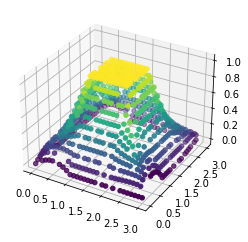

Error: 20.639
Time: 91.109


In [58]:
test_norm(hamacher_product)